In [43]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$ \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})}, $$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$	 f(\mathbf{x}) + g(\mathbf{x}). $$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [44]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k : int
    #FILL

In [45]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k, k = state
    #FILL
    d_k = f.grad(x_k)+g.subgrad(x_k)
    alpha_k = 0.1/np.sqrt(k)
    next_x_k = x_k - alpha_k*d_k

    return SubG_state(next_x_k, k=k+1)

def SubG_initialize(composite_function, x_zero):
    #FILL
    return SubG_state(x_zero, k=1)

In [46]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

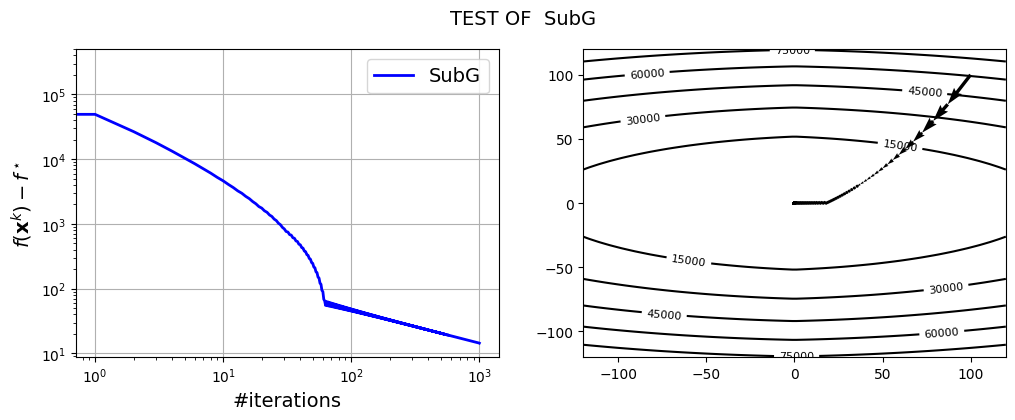

In [47]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


$\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z})= \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^p}\{ \gamma g_{\ell_1}(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\} = \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^p}\{ \gamma \|\mathbf{\mathbf{y}}\|_1 + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}$

We can find the solution by subdifferentiating $\gamma \|\mathbf{\mathbf{y}}\|_1 + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\ $ with respect to $\mathbf{y}$ and find where it reaches $0$. It gives:

$\gamma \mathrm{sign}(\mathbf{y}) + \mathbf{y} - \mathbf{z}=0$ and we find $\mathbf{y}=\mathbf{z} -\gamma \mathrm{sign}(\mathbf{y})$

So for every element i, we have: $y_i = z_i - \gamma \mathrm{sign}(y_i)$

We now analyze the different cases:

$z_i>\gamma$ : we will have $y_i = z_i - \gamma \mathrm{sign}(y_i)$ positive and so $y_i = z_i - \gamma$

$z_i< -\gamma$ : we will have $y_i = z_i - \gamma \mathrm{sign}(y_i)$ negative and so $y_i = z_i + \gamma$

$ -\gamma \leq z_i \leq \gamma$: we will have $y_i =0$. We can explain this by taking $ 0< z_i \leq \gamma$. If we suppose $y_i >0$, we will have $\mathrm{sign}(y_i)=1$ and so $z_i-\gamma \leq 0$ and this would go against our supposition that $y_i >0$. The same reasoning can be applied for $ 0> z_i \geq -\gamma$.

We can then see that $y_i = \max(|z_i|-\gamma,0)\mathrm{sign}(z_i)$ and thus proving that $\mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+$

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [48]:
def l1_prox(gamma, z):
    #FILL
    gl1_prox = np.maximum(np.abs(z)-gamma, 0)*np.sign(z)
    return gl1_prox

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [49]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    #FILL
    alpha_k : float

In [50]:
def ISTA_update(composite_function, state):
    #FILL
    x_k, alpha_k = state
    f, _ = composite_function
    z = x_k-alpha_k*f.grad(x_k)
    next_x_k = l1_prox(alpha_k, z)

    return ISTA_state(next_x_k, alpha_k)

def ISTA_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    alpha_k = 2/(f.lips_grad+f.strng_cvx)
    return ISTA_state(x_zero, alpha_k)

In [51]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

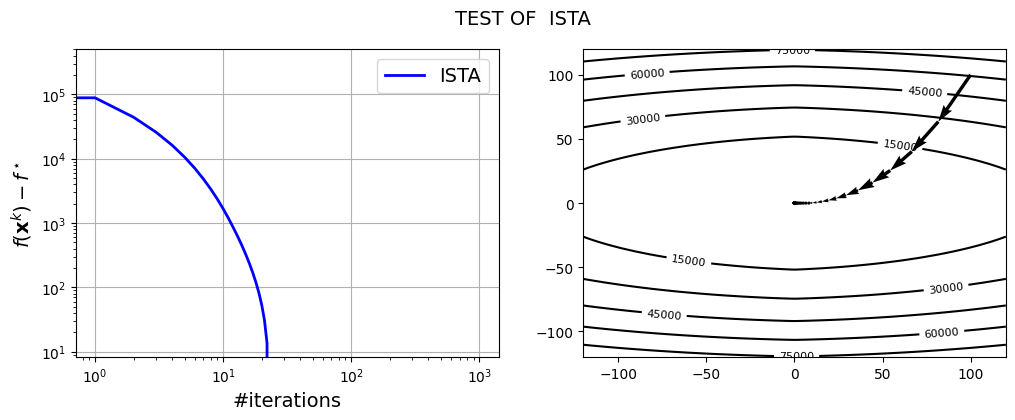

In [52]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [53]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    #FILL
    y_k : Vector
    c_f : float
    alpha_k : float

In [54]:
import numpy

def FISTA_update(composite_function, state):
    #FILL
    f, g = composite_function
    x_k, y_k, c_f, alpha_k = state
    
    z = y_k-alpha_k*f.grad(y_k)

    next_x_k = l1_prox(alpha_k, z)
    next_y_k = next_x_k + ((np.sqrt(c_f)-1)/(np.sqrt(c_f)+1))*(next_x_k-x_k)

    return FISTA_state(next_x_k, next_y_k, c_f, alpha_k)

def FISTA_initialize(composite_function, x_zero):
    #FILL
    f, g = composite_function
    c_f = f.lips_grad/f.strng_cvx
    alpha_k = 1/f.lips_grad
    return FISTA_state(x_zero, x_zero, c_f, alpha_k)

In [55]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

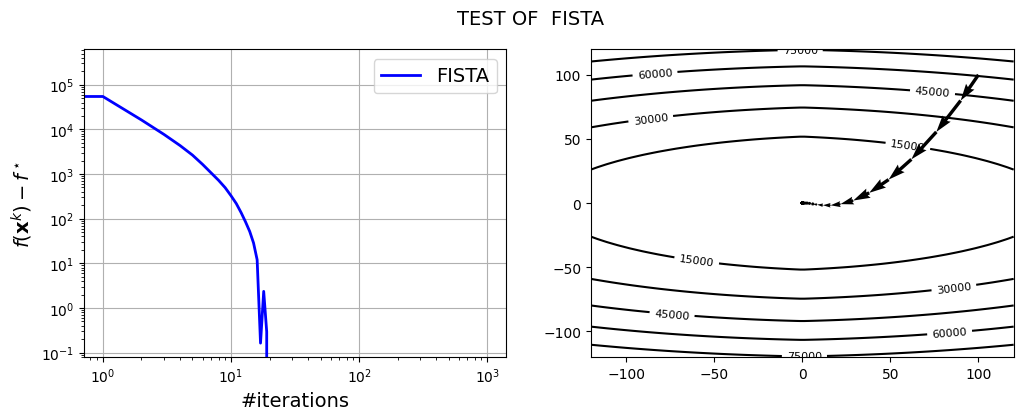

In [56]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

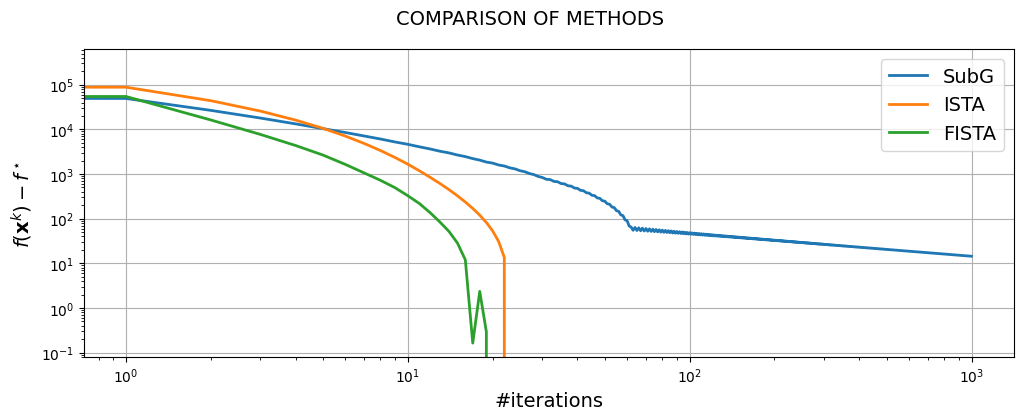

In [57]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

We see that SubG is a straight line on the log-log plot at about 600 iterations, which means it is sublinear.
ISTA and FISTA are converging linearly, with FISTA converging a bit faster.

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

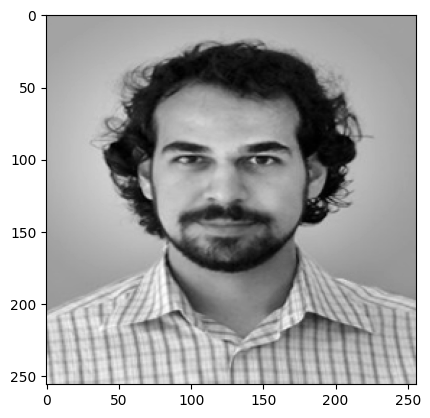

In [58]:
from lib.inpainting import *

image = load("lib/alp.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

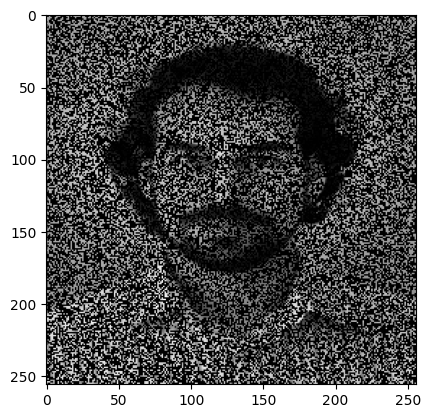

In [59]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [60]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x)#FILL

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [72]:
mu = 1e-1 # Desired strong convexity of f
def f_l1(alpha):
    #FILL
    return 1/2*np.linalg.norm(b-P(W_T(alpha)))**2

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [73]:
def grad_f_l1(alpha):
    #FILL
    return -W(P_T(b-P(W_T(alpha))))

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

We first compute the Hessian of $f_{\ell_1}(\mathbf{\alpha})$, which is just $\mathbf{W}\mathbf{P}^\top_{\Omega}\mathbf{P}_{\Omega}\mathbf{W^\top}$.

Now we have to found L s.t. $\mathbf{W}\mathbf{P}^\top_{\Omega}\mathbf{P}_{\Omega}\mathbf{W^\top} \leq L\mathbf{I}$

We can use the fact that L is equal to the maximum eigenvalue of $\mathbf{W}\mathbf{P}^\top_{\Omega}\mathbf{P}_{\Omega}\mathbf{W^\top}$. We also assumed that $\mathbf{W}$ is an orthonormal basis. The important information is that the basis is normed, so $\mathbf{W}$ and $\mathbf{W^\top}$ do not affect the maximum eigenvalue. We also have that $\mathbf{P}_{\Omega}$ subsamples the pixels, so the maximum eigenvalue is $1$.

In [74]:
lips_grad_f_l1 = 1#FILL

We have all the necessary ingredients to define the smooth part of our composite objective:

In [75]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [76]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [77]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [78]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

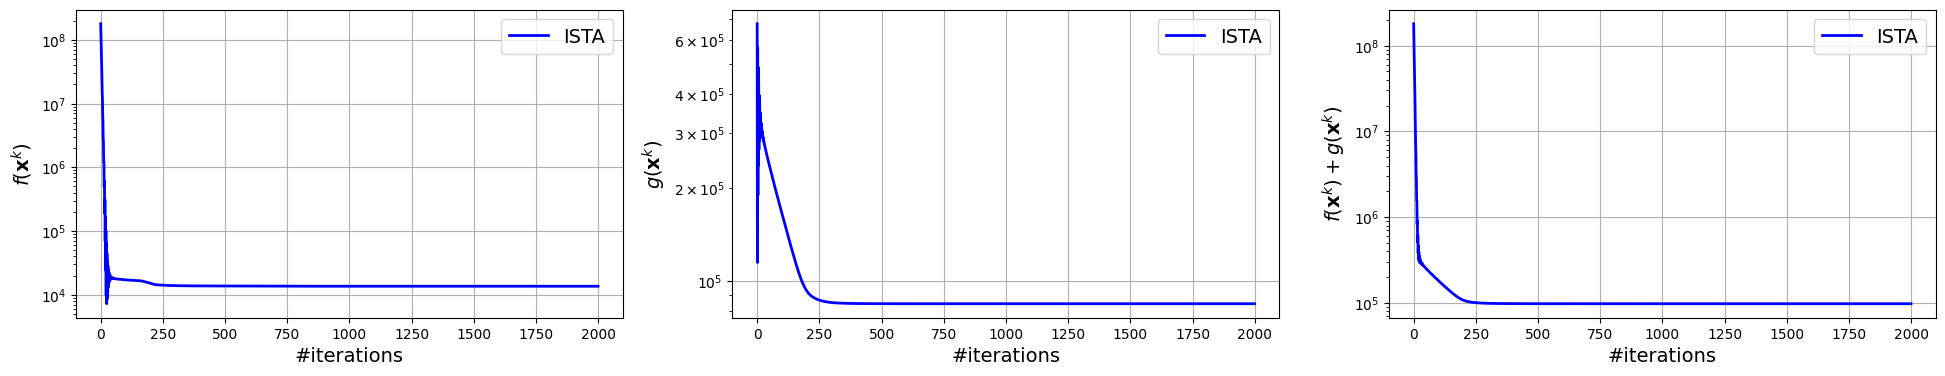

In [79]:
output = solve_composite(list_of_methods[1], composite_objective, lmda=0.1, max_iterations=2000)
flat_image_out = W_T(output)
image_out = flat_image_out.reshape(image.shape)

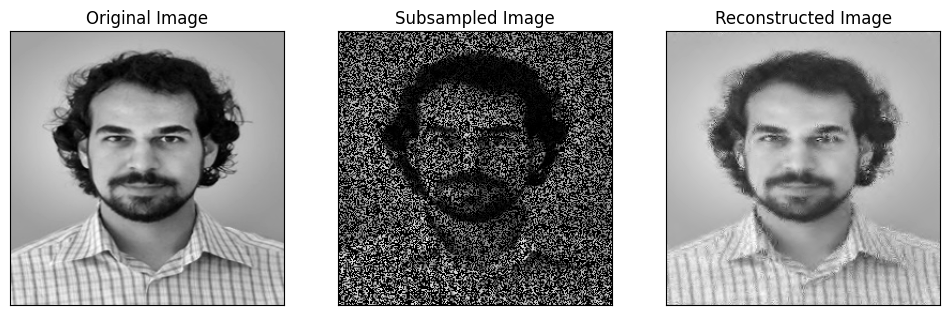

In [80]:
show(true = image, subsampled=subsampled, estimated=image_out)